# Generalised Linear Models on Motor Insurance Claims Project.

This example illustrates the use of Poisson, Gamma and Tweedie regression on the `French Motor Third-Party Liability Claims dataset` <https://www.openml.org/d/41214>.

In this dataset, each sample corresponds to an insurance policy, i.e. a contract within an insurance company and an individual (**policyholder**). Available features include driver age, vehicle age, vehicle power, etc.

`A few definitions`:
* A ***claim*** is the request made by a policyholder to the insurer to compensate for a loss covered by the insurance. The claim amount is the amount of money that the insurer must pay. The exposure is the duration of the insurance coverage of a given policy, in years.

* A **policy*** is a contract between an insurance company and an individual: the policyholder, that is, the vehicle driver in this case.

* **Exposure** is the duration of the insurance coverage of a given policy, in years.

* The **claim frequency** is the number of claims divided by the exposure, typically measured in number of claims per year.

Here our goal is to predict the expected value, i.e. the mean, of the **total claim amount *per* exposure unit** also referred to as the **pure premium**.

There are several possibilities to do that, two of which are:

1. Model the number of claims with a Poisson distribution, and the average claim amount per claim, also known as severity, as a Gamma distribution and multiply the predictions of both in order to get the total claim amount.

2. Model the total claim amount per exposure directly, typically with a Tweedie distribution of Tweedie power $p \in (1, 2)$.

In this example we will illustrate both approaches. We start by defining a few helper functions for loading the data and visualizing results

1.
A. Noll, R. Salzmann and M.V. Wuthrich, Case Study: French Motor Third-Party Liability Claims (November 8, 2018). `https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764`

In [1]:
%matplotlib inline

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from sklearn.metrics import mean_tweedie_deviance
from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

## Loading the French Motor Third-Party Liability Claims Dataset.

We will also perform Exploratory Data Analysis(EDA) to get a feel of the data before proceeding with defining helper models.

## 1. Exploratory Data Analysis(EDA).

In [2]:
#fetch French Motor TPL claims dataset
freqData = fetch_openml(data_id=41214, as_frame=True)

# Extract feature matrix X and show 5 random Samples
df_X = freqData['frame']

#### 1. Structure Investigation.
General Structure of the dataset.
- How many columns and rows?, How many different data types those features include?

In [3]:
# show size of the Dataset

df_X.shape

(678013, 12)

In [4]:


# Count how many times each data type is present in the dataset
pd.value_counts(df_X.dtypes)

float64     8
category    1
category    1
object      1
category    1
dtype: int64

In [5]:
# Structure of non-numerical features
df_X.describe(exclude='number')

,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,C,B12,Regular,R24
freq,191880,166024,345877,160601


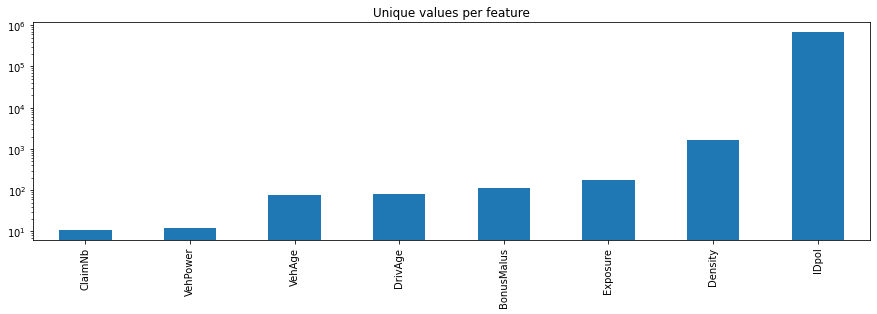

In [6]:
# Structure of numerical features
## This process will give us some insights about the number of binary(2 unique), ordinal(3-10 unique) and continous(more than 10 unique values) feautures in the dataset.

# For each numerical feature compute number of unique entries
unique_values = df_X.select_dtypes(include='number').nunique().sort_values()

#plot with y-axis in log scale

unique_values.plot.bar(logy=True, figsize=(15,4),
                      title='Unique values per feature');

In [7]:
#alternatively use

df_X.info() #or df_X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678013 non-null  float64 
 1   ClaimNb     678013 non-null  float64 
 2   Exposure    678013 non-null  float64 
 3   Area        678013 non-null  category
 4   VehPower    678013 non-null  float64 
 5   VehAge      678013 non-null  float64 
 6   DrivAge     678013 non-null  float64 
 7   BonusMalus  678013 non-null  float64 
 8   VehBrand    678013 non-null  category
 9   VehGas      678013 non-null  object  
 10  Density     678013 non-null  float64 
 11  Region      678013 non-null  category
dtypes: category(3), float64(8), object(1)
memory usage: 48.5+ MB


#### 2. Quality Investigation.

The goal is to have a global view on the dataset with regards to *duplicates, missing values and recording errors*

In [8]:
# Duplicates

## check the no of duplicates while ignoring Region feature

n_duplicates = df_X.drop(labels=['Region'], axis=1).duplicated().sum()

print(f'You seem to have {n_duplicates} duplicates in your database.')

You seem to have 0 duplicates in your database.


In [9]:
# Extract column names of all features, except 'Region'

columns_to_consider = df_X.drop(labels=['Region'], axis=1).columns

# Drop duplicates based on columns_to_consider
df_X = df_X.drop_duplicates(subset=columns_to_consider)
df_X.shape #remember we have 0 duplicates in our dataset

(678013, 12)

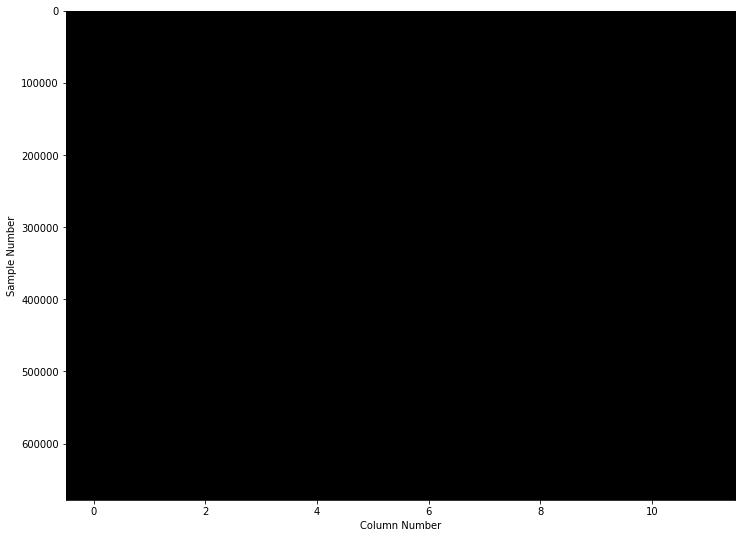

In [10]:
# Missing Values

## we want to identify features with missing values
### visualize using df_X.isna()

plt.figure(figsize=(12,9))
plt.imshow(df_X.isna(), aspect='auto',
          interpolation='nearest', cmap='gray')

plt.xlabel('Column Number')
plt.ylabel('Sample Number');

we have 0 missing values in 12 columns in all 678000 samples.

A better approach is to use missingno library.


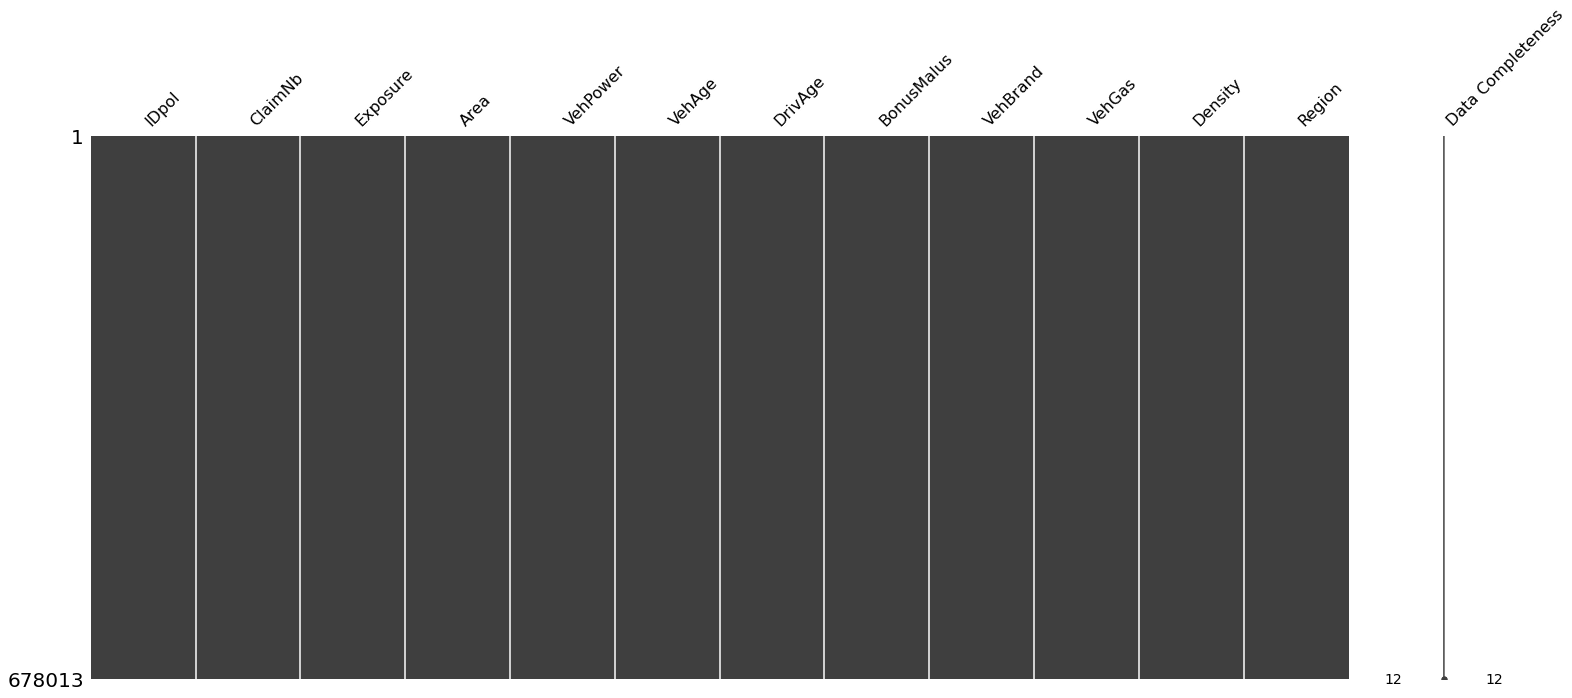

In [11]:
import missingno as msno

msno.matrix(df_X, labels=True, sort='descending');

Where 20% of the feature values are missing, we resort to dropping the columns

**code**:

*df_X = df_X.dropna(tresh=df_X.shape[1] *0.80,axis=0).reset_index(drop=True)  
df_X.shape*

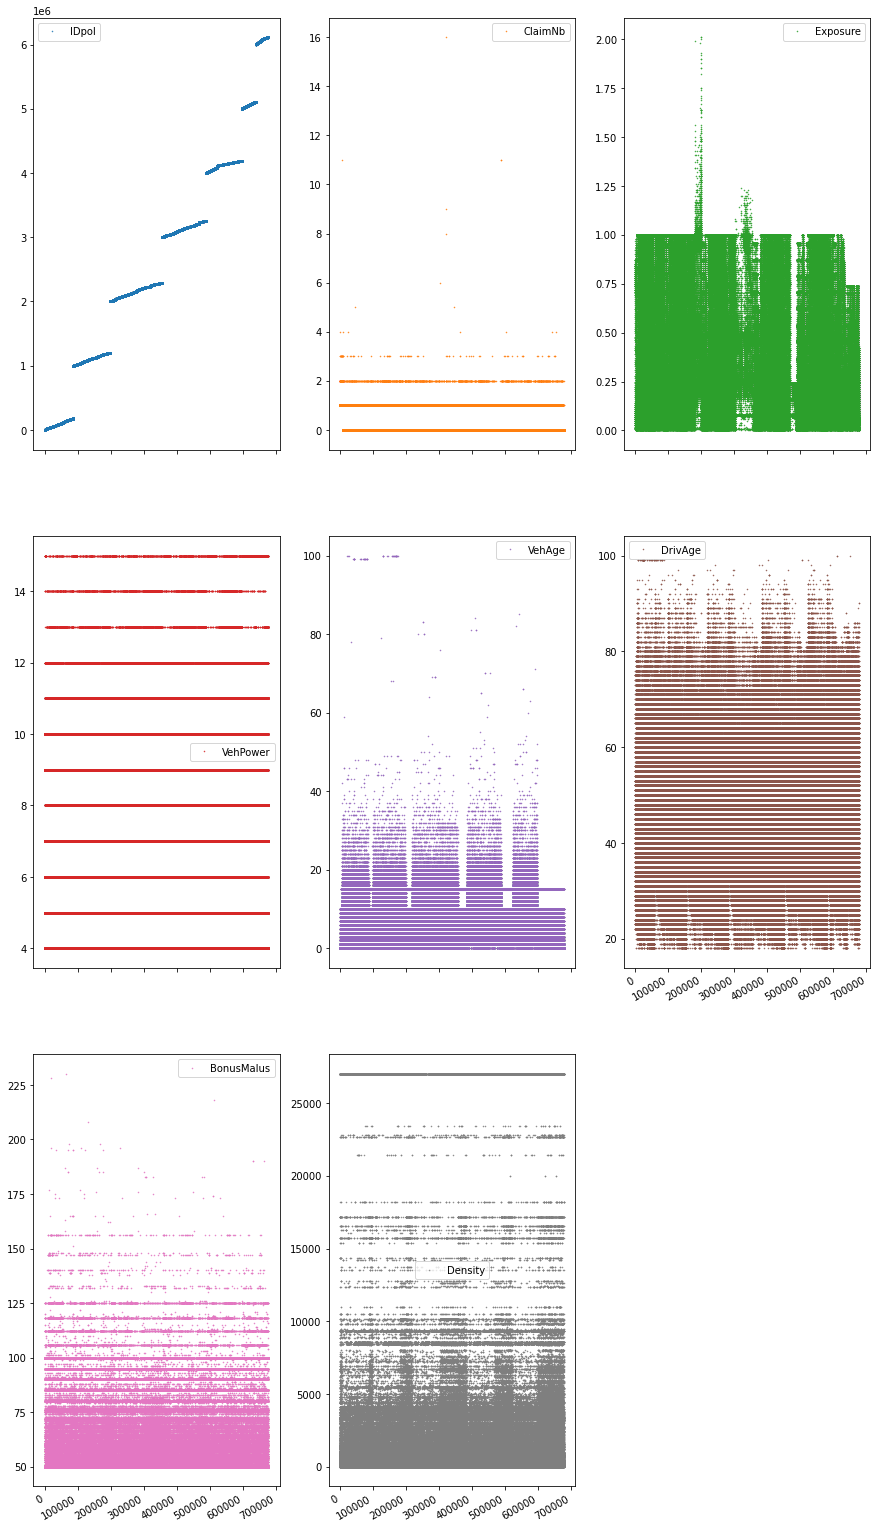

In [12]:
# Recording errors

## Numerical features
### we will use .plot() function and combine it with the following parameters:

###lw=0: lw= linewidth. 0 means we dont show lines
### marker='.': we use . as markers for each data point
### subplots=True: pandas will plot each feature in a separate plot
### layout=(-1,3): how many rows and columns to use for the subplots. -1 means as many as needed while 2 means use 2 columns per row
### markersize=1: makes sure the figure height is roughly the no of features.


df_X.plot(lw=0, marker='.',
         subplots=True, layout=(-1,3),
         figsize=(15, 30), markersize=1);

Each point in this figure is a sample(row) in our dataset and each subplot represents a different feature(column)
y axis shows the feature, while x axis is the sample index.

In [13]:
# Recording errors 

## Non numerical features
df_X.describe(exclude=['number','datetime'])

,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,C,B12,Regular,R24
freq,191880,166024,345877,160601


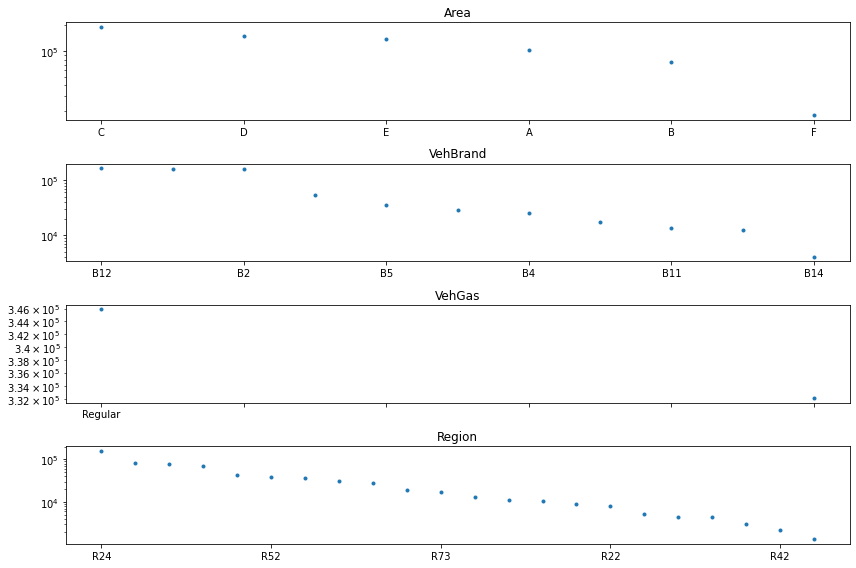

In [14]:
# all of them will require a follow up investigation.
# to showcase this solution, we can loop through all non numeric features and plot for each the no of occurences per unique value.

#create figure with 4 subplots

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(12,8))

#identify non numerical features
df_non_numerical=df_X.select_dtypes(exclude=['number','datetime'])

#loop through features and put each subplot on a matplotlib axis object

for col, ax in zip(df_non_numerical.columns, ax.ravel()):
    
    #selects one single feature and counts no of unique value
    
    df_non_numerical[col].value_counts().plot(logy=True,
                                             title=col, lw=0,
                                             marker='.', ax=ax)
    plt.tight_layout();

#### 3. Feature Distribution.
value distribution of each feature is a great way to better understand the content of your data.
the quickest way to do this is using histogram plots.

using pandas.

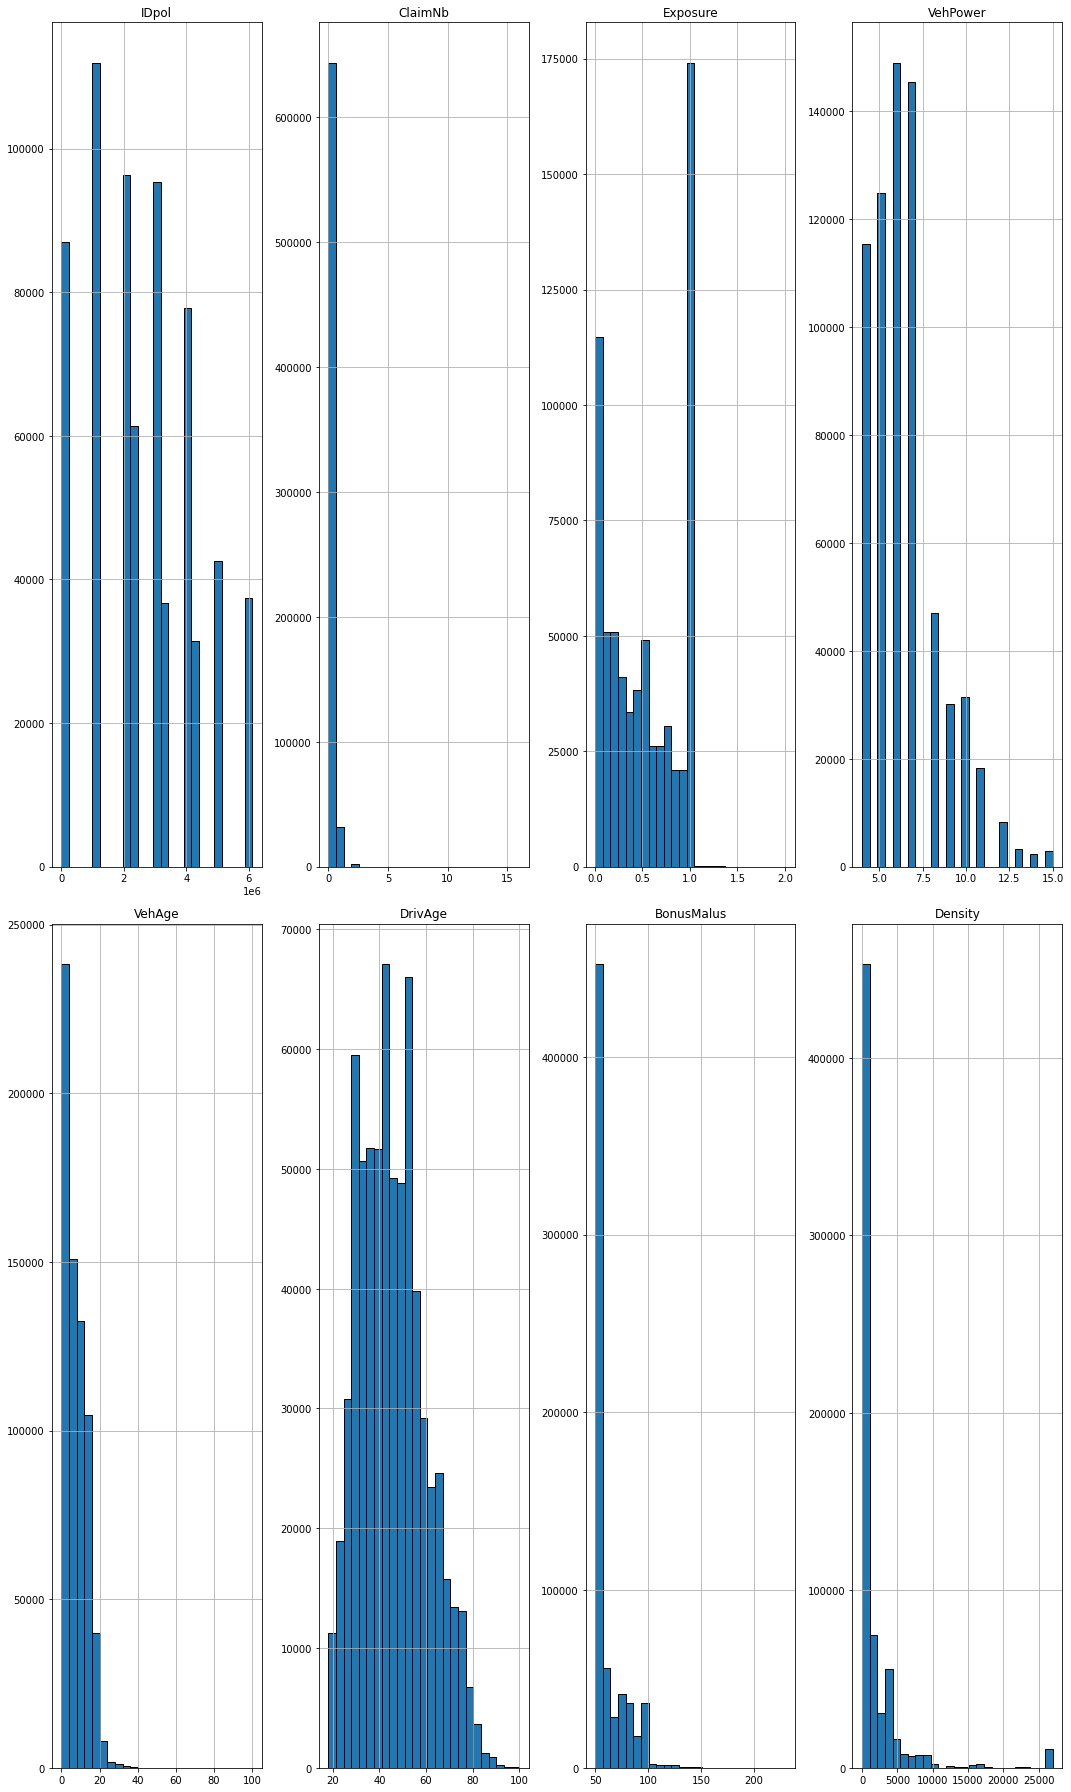

In [15]:
# plots histogram for each numerical feature in a separate subplot.
df_X.hist(bins=25, figsize=(15, 25),
         layout=(-1, 4), edgecolor='black')
plt.tight_layout();

**Most frequent entry**: a feature such as `claimsNb` mostly contains entries in one category.
    
using the `.mode()` function, we can extract the ratio of the most frequent entry for each feature and visualize the information.

IDpol         1.000000
VehGas        0.000001
VehBrand      0.000001
BonusMalus    0.000001
Region        0.000000
dtype: float64

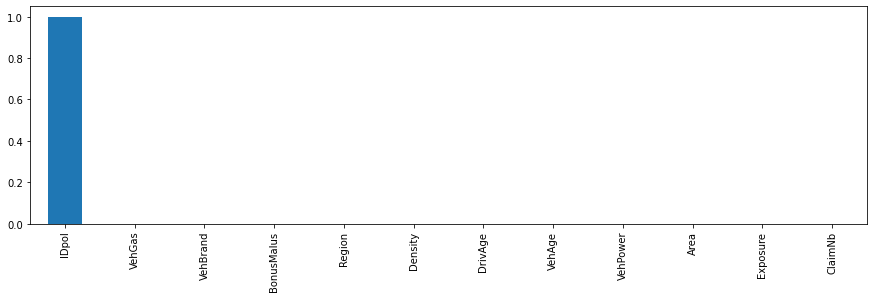

In [16]:
#most frequent entry
most_frequent_entry = df_X.mode()

#checks for each entry if i contains most frequent entry
df_freq = df_X.eq(most_frequent_entry.values, axis=1)

#computes mean of the 'is most frequent' occurence
df_freq = df_freq.mean().sort_values(ascending=False)

#show top 5 features with highest ratio of singular content
display(df_freq.head())

#visualize the 'df_freq' table
df_freq.plot.bar(figsize=(15, 4));

## summary

Indepth EDA is time consuming and usually takes upto 80% of a data science project.

This dataset has no missing or duplicate datasets hence we can just proceed to data modeling, this was purposely for tutorial purposes when dealing with huge datasets with missing values.

## 2. Modeling.

In [17]:
def load_fmtpl(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims(FMTPL) dataset.
    
    Parameters
    ----------
    n_samples: int, default=100000
     number of samples to select(for faster run time). full dataset has 678013 samples.
     """
    
    #frequency dataset
    #FMTPLCfreq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
    df_freq['IDpol'] = df_freq['IDpol'].astype(int)
    df_freq.set_index('IDpol', inplace=True)
    
    #severity dataset
    #FMTPLCsev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']
    
    # sum ClaimAmount over identical IDs
    def_sev = df_sev.groupby('IDpol').sum()
    
    df = df_freq.join(df_sev, how='left')
    df['ClaimAmount'].fillna(0, inplace=True)
    
    #unquote string fields
    
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip('')
    return df.iloc[:n_samples]

In [18]:
def plot_obs_pred(
    df,
    feature,
    weight,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


In [27]:
def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),  # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

### Loading datasets, basic feature extraction and target definitions.

We construct the FMTPLC dataset by joining the FMTPLCfreq table, containing the number of claims `(ClaimNb)`, with the FMTPLCsev table, containing the claim amount `(ClaimAmount)` for the same policy ids `(IDpol)`.

In [20]:
df = load_fmtpl(n_samples=60000)

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

with pd.option_context("display.max_columns", 15):
    print(df[df.ClaimAmount > 0].head())

C:\Users\9Bulletsnroaches\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  ...  \
IDpol                                                                 ...   
1          1.0      0.10    D       5.0     0.0     55.0        50.0  ...   
3          1.0      0.77    D       5.0     0.0     55.0        50.0  ...   
5          1.0      0.75    B       6.0     2.0     52.0        50.0  ...   
10         1.0      0.09    B       7.0     0.0     46.0        50.0  ...   
11         1.0      0.84    B       7.0     0.0     46.0        50.0  ...   

      Density Region      IDpol ClaimAmount   PurePremium  Frequency  \
IDpol                                                                  
1      1217.0    R82  1010996.0     1128.12  11281.200000  10.000000   
3      1217.0    R82  4007252.0     1204.00   1563.636364   1.298701   
5        54.0    R22  4073956.0     1204.00   1605.333333   1.333333   
10       76.0    R72  4038917.0       77.20    857.777778  11.111111   
11       76.0    R72  407804

### Frequency model – Poisson distribution.

The number of claims `(ClaimNb)` is a positive integer (0 included). Thus, this target can be modelled by a Poisson distribution. It is then assumed to be the number of discrete events occurring with a constant rate in a given time interval (`Exposure`, in units of years). Here we model the frequency `y = ClaimNb / Exposure`, which is still a (scaled) Poisson distribution, and use `Exposure` as `sample_weight`.

In [29]:
df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

# The parameters of the model are estimated by 
#minimizing the Poisson deviance on the training set via a quasi-Newton solver: L-BFGS
# Some features are collinear, we use a weak penalization to avoid numerical issues.

# Generalized Linear Model(glm)

glm_freq = PoissonRegressor(alpha=1e-3, max_iter=400)
glm_freq.fit(X_train, df_train['Frequency'], sample_weight=df_train['Exposure'])

scores = score_estimator(glm_freq,
                        X_train, X_test,
                        df_train, df_test,
                        target='Frequency',
                        weights='Exposure')

print('Evaluation of poissonRegressor on target Frequency')
print(scores)

Evaluation of poissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.3218  0.3252
mean abs. error     0.3930  0.3895
mean squared error  2.7798  2.9956


We can visually compare observed and predicted values, aggregated by the drivers age (`DrivAge`), vehicle age (`VehAge`) and the insurance bonus/malus (`BonusMalus`).

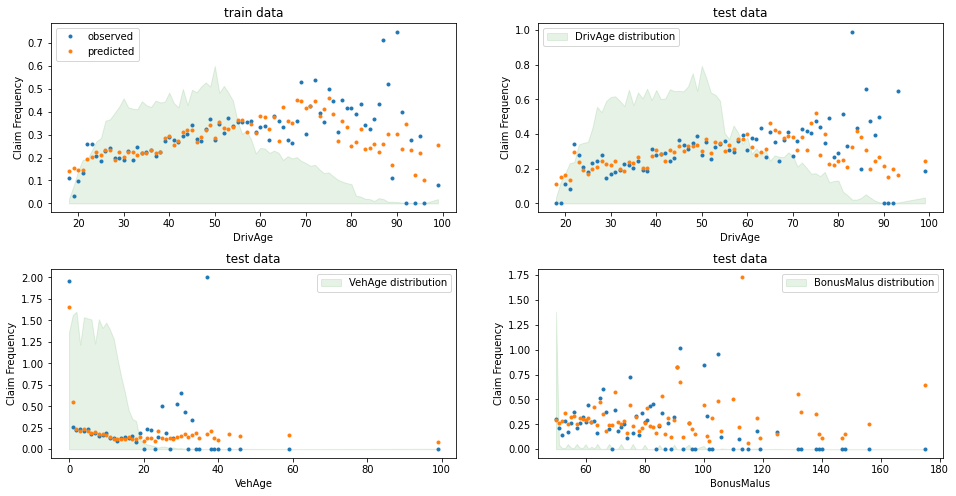

In [30]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(df=df_train,
             feature='DrivAge',
             weight = 'Exposure',
             observed = 'Frequency',
             predicted=glm_freq.predict(X_train),
             y_label='Claim Frequency',
             title='train data',
             ax = ax[0, 0])

plot_obs_pred(df=df_test,
             feature='DrivAge',
             weight='Exposure',
             observed='Frequency',
             predicted=glm_freq.predict(X_test),
             y_label='Claim Frequency',
             title='test data',
             ax=ax[0, 1],
             fill_legend=True)

plot_obs_pred(df=df_test,
             feature='VehAge',
             weight='Exposure',
             observed='Frequency',
             predicted=glm_freq.predict(X_test),
             y_label='Claim Frequency',
             title='test data',
             ax = ax [1, 0],
             fill_legend=True)

plot_obs_pred(df=df_test,
             feature = 'BonusMalus',
             weight='Exposure',
             observed='Frequency',
             predicted=glm_freq.predict(X_test),
             y_label='Claim Frequency',
             title='test data',
             ax=ax[1, 1],
             fill_legend=True)


According to the observed data, the frequency of accidents is higher for drivers younger than 30 years old, and is positively correlated with the `BonusMalus` variable. Our model is able to mostly correctly model this behaviour.

## Severity Model -  Gamma distribution
The mean claim amount or severity (`AvgClaimAmount`) can be empirically
shown to follow approximately a Gamma distribution. We fit a GLM model for
the severity with the same features as the frequency model.

Note:

- We filter out ``ClaimAmount == 0`` as the Gamma distribution has support
  on $(0, \infty)$, not $[0, \infty)$.
- We use ``ClaimNb`` as `sample_weight` to account for policies that contain
  more than one claim.



In [31]:
mask_train = df_train['ClaimAmount'] > 0
mask_test = df_test['ClaimAmount'] > 0

glm_sev = GammaRegressor(alpha=5.0, max_iter=10000)

glm_sev.fit(X_train[mask_train.values],
           df_train.loc[mask_train, 'AvgClaimAmount'],
           sample_weight = df_train.loc[mask_train, 'ClaimNb'])

scores = score_estimator(glm_sev,
                        X_train[mask_train.values],
                        X_test[mask_test.values],
                        df_train[mask_train],
                        df_test[mask_test],
                        target='AvgClaimAmount',
                        weights='ClaimNb')

print('Evaluation of GammaRegressor on target AvgClaimAmount')
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        5.200000e-03 -5.700000e-03
mean abs. error     1.685445e+03  1.635148e+03
mean squared error  5.922315e+07  4.339962e+07


Here, the scores for the test data call for caution as they are significantly worse than for the training data indicating an overfit despite the strong regularization.

**Note** that the resulting model is the average claim amount per claim. As such, it is conditional on having at least one claim, and cannot be used to predict the average claim amount per policy in general.

In [34]:
print('Mean AvgClaim Amount per policy:  %.2f' 
      % df_train['AvgClaimAmount'].mean())

print('Mean AvgClaim Amount | NbClaim > 0: %.2f' 
      % df_train['AvgClaimAmount'][df_train['AvgClaimAmount'] >0].mean())

print('predicted Mean AvgClaim Amount | NbClaim > 0: %.2f' 
      % glm_sev.predict(X_train).mean())

Mean AvgClaim Amount per policy:  335.90
Mean AvgClaim Amount | NbClaim > 0: 1942.14
predicted Mean AvgClaim Amount | NbClaim > 0: 1862.08


We can visually compare observed and predicted values, aggregated for the drivers age (`DrivAge`).

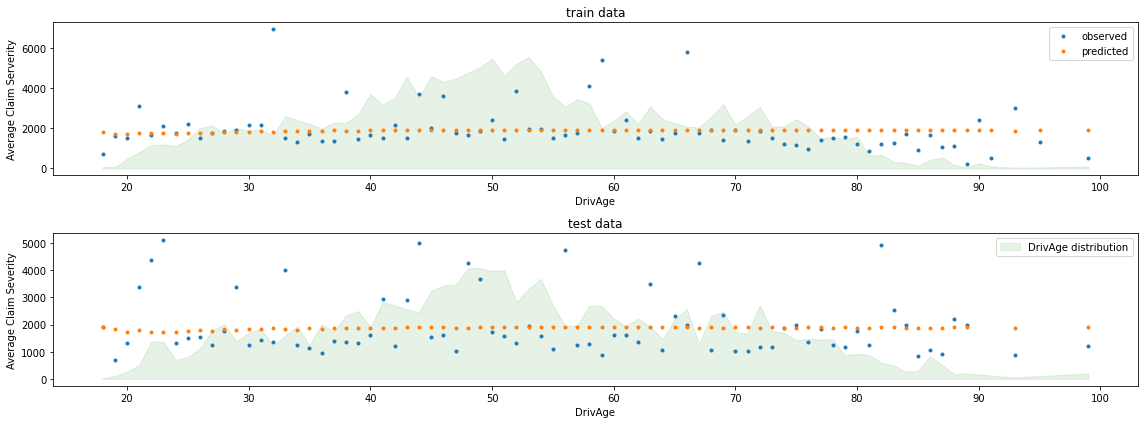

In [37]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(df=df_train.loc[mask_train],
             feature='DrivAge',
             weight='Exposure',
             observed='AvgClaimAmount',
             predicted=glm_sev.predict(X_train[mask_train.values]),
             y_label='Average Claim Serverity',
             title='train data',
             ax=ax[0])

plot_obs_pred(df=df_test.loc[mask_test],
              feature="DrivAge",
              weight="Exposure",
              observed="AvgClaimAmount",
              predicted=glm_sev.predict(X_test[mask_test.values]),
              y_label="Average Claim Severity",
              title="test data",
              ax=ax[1],
              fill_legend=True)

plt.tight_layout()

Overall, the drivers age (``DrivAge``) has a weak impact on the claim
severity, both in observed and predicted data.

## Pure Premium Modeling via a Product Model vs single TweedieRegressor
As mentioned in the introduction, the total claim amount per unit of
exposure can be modeled as the product of the prediction of the
frequency model by the prediction of the severity model.

Alternatively, one can directly model the total loss with a unique
Compound Poisson Gamma generalized linear model (with a log link function).
This model is a special case of the Tweedie GLM with a "power" parameter
$p \in (1, 2)$. Here, we fix apriori the `power` parameter of the
Tweedie model to some arbitrary value (1.9) in the valid range. Ideally one
would select this value via grid-search by minimizing the negative
log-likelihood of the Tweedie model, but unfortunately the current
implementation does not allow for this (yet).

We will compare the performance of both approaches.
To quantify the performance of both models, one can compute
the mean deviance of the train and test data assuming a Compound
Poisson-Gamma distribution of the total claim amount. This is equivalent to
a Tweedie distribution with a `power` parameter between 1 and 2.

The :func:`sklearn.metrics.mean_tweedie_deviance` depends on a `power`
parameter. As we do not know the true value of the `power` parameter, we here
compute the mean deviances for a grid of possible values, and compare the
models side by side, i.e. we compare them at identical values of `power`.
Ideally, we hope that one model will be consistently better than the other,
regardless of `power`.



In [38]:
glm_pure_premium = TweedieRegressor(power=1.9, alpha=0.1, max_iter=10000)
glm_pure_premium.fit(
    X_train, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_product_model, scores_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("Product Model", "TweedieRegressor"),
)
print("Evaluation of the Product Model and the Tweedie Regressor on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                          Product Model               TweedieRegressor              
subset                            train          test            train          test
D² explained                        NaN           NaN     6.600000e-02  6.410000e-02
mean Tweedie dev p=1.5000  1.111717e+02  1.071890e+02     1.093661e+02  1.080014e+02
mean Tweedie dev p=1.7000  4.356360e+01  4.248690e+01     4.272230e+01  4.246920e+01
mean Tweedie dev p=1.8000  3.254330e+01  3.197250e+01     3.200980e+01  3.190430e+01
mean Tweedie dev p=1.9000  3.290650e+01  3.260720e+01     3.257660e+01  3.254110e+01
mean Tweedie dev p=1.9900  1.801713e+02  1.801161e+02     1.799603e+02  1.800639e+02
mean Tweedie dev p=1.9990  1.697335e+03  1.698417e+03     1.697133e+03  1.698366e+03
mean Tweedie dev p=1.9999  1.687244e+04  1.688481e+04     1.687224e+04  1.688476e+04
mean abs. error            8.703844e+02  8.503656e+02     8.372107e+02

Finally, we can compare the two models using a plot of cumulated claims: for
each model, the policyholders are ranked from safest to riskiest and the
fraction of observed total cumulated claims is plotted on the y axis. This
plot is often called the ordered Lorenz curve of the model.

The Gini coefficient (based on the area under the curve) can be used as a
model selection metric to quantify the ability of the model to rank
policyholders. Note that this metric does not reflect the ability of the
models to make accurate predictions in terms of absolute value of total
claim amounts but only in terms of relative amounts as a ranking metric.

Both models are able to rank policyholders by risky-ness significantly
better than chance although they are also both far from perfect due to the
natural difficulty of the prediction problem from few features.

Note that the Gini index only characterize the ranking performance of the
model but not its calibration: any monotonic transformation of the
predictions leaves the Gini index of the model unchanged.

Finally one should highlight that the Compound Poisson Gamma model that
is directly fit on the pure premium is operationally simpler to develop and
maintain as it consists in a single scikit-learn estimator instead of a
pair of models, each with its own set of hyperparameters.



[]

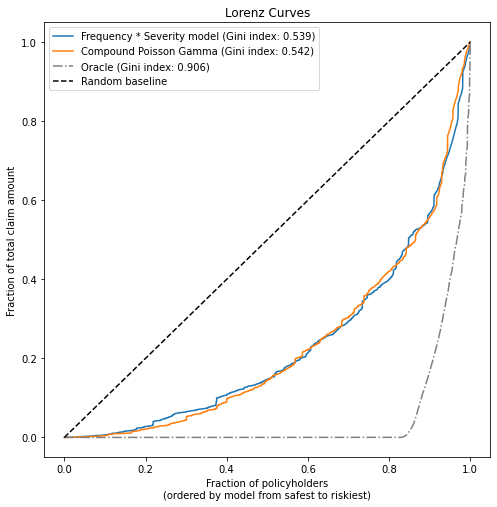

In [40]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_product = glm_freq.predict(X_test) * glm_sev.predict(X_test)
y_pred_total = glm_pure_premium.predict(X_test)

for label, y_pred in [
    ("Frequency * Severity model", y_pred_product),
    ("Compound Poisson Gamma", y_pred_total),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()